In [459]:
# 학습 파일 shuffle
# import random
# with open('./train_hate_dataset_v1.txt', 'r', encoding='utf-8') as f:
#     file = f.read()
# files = file.split('\n')
# with open('./test_hate_dataset_v1.txt', 'r', encoding='utf-8') as f:
#     file2 = f.read()
# files2 = file2.split('\n')
# files.extend(files2)
# random.shuffle(files)
# sentences = [x.split('\t') for x in files]
# len_sentences = len(sentences)
# splited_len = round(len_sentences*0.9)
# train_sentences = sentences[:splited_len]
# test_sentences = sentences[splited_len:]
# train_sentences = pd.DataFrame(train_sentences)
# test_sentences = pd.DataFrame(test_sentences)
# train_sentences.to_csv('./train_hate_dataset_v2.txt', sep='\t', index=None, header=None)
# test_sentences.to_csv('./test_hate_dataset_v2.txt', sep='\t', index=None, header=None)

In [24]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import jamotools #자모 단위 토큰화
import re
import gluonnlp as nlp
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from gluonnlp.data import SentencepieceTokenizer
from kobert.utils import get_tokenizer

class CharDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, mode):
        self.sentences = [line[sent_idx] for line in dataset]
        self.labels = [int(line[label_idx]) for line in dataset]
        self.korean = re.compile('[^1!ㄱ-ㅣ가-힣]+')
        self.mode = mode
        tok_path = '/home/yeonsik/kobert/kobert_news_wiki_ko_cased-1087f8699e.spiece'
        self.sp = SentencepieceTokenizer(tok_path)
        self.vocab = self.make_vocab()
        self.vocab_size = len(self.vocab)
        self.q3 = self.get_q3()
        self.char2idx = {u:i for i, u in enumerate(self.vocab)}
        self.idx2char = {i:u for i, u in enumerate(self.vocab)}
        self.max_len = self.find_max_len()
        
    def __getitem__(self, i):
        return (self.preprocess_sentence(self.sentences[i]), torch.tensor(self.labels[i]).to(torch.float32))
    
    def __len__(self):
        return len(self.labels)
    
    def make_vocab(self):
        vocab = ''
        for sentence in self.sentences:
            vocab+=' '+sentence
        vocab = self.make_token(vocab)
        vocab = set(vocab)
        vocab = sorted(vocab)
        vocab.append('<UNK>') #######
        vocab.append('<PAD>')
        return vocab
    
    def make_token(self, sentence):
        if self.mode == 'jamo':
            chars = self.korean.sub('', jamotools.split_syllables(sentence))
            return list(chars)
        elif self.mode == 'char':
            chars = self.korean.sub('', sentence)
            return list(chars)
        elif self.mode == 'sentencepiece':
            return self.sp(sentence)
    
    def preprocess_sentence(self, sentence):
        chars = self.make_token(sentence)
        if len(chars) < self.q3:
            need_pad = self.q3 - len(chars)
            chars.extend(['<PAD>']*need_pad)
        else:
            chars = chars[:self.q3]
        chars = torch.tensor([self.char2idx[x] for x in chars]).to(torch.int64)
        return chars
    
    def find_max_len(self):
        return max(len(self.make_token(item)) for item in self.sentences)
    
    def find_max_idx(self):
        return self.sentences[np.argmax([len(self.make_token(item)) for item in self.sentences])]

    
    def get_q3(self):
        values = np.array([len(self.make_token(x)) for x in self.sentences])
        return int(np.quantile(values, 0.75))
    
    
    def plot_len(self):
        values = np.array([len(self.make_token(x)) for x in self.sentences])
        plt.hist(values, density=True, bins=80)
        plt.ylabel('count')
        plt.xlabel('length of sequence')
        plt.show()
        print('문장 최대 길이 :',self.max_len)
        results = stats.describe(values)
        print('min={}, max={}, mean={}, Q2={} Q3={}'.format(results[1][0], results[1][1], results[2],
                                                          np.median(values), np.quantile(values, 0.75)))
        

In [25]:
class Net(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim, hidden_size, n_layers):
        super().__init__()
        self.dropout_prob = 0.5
        self.embedding_dim = embedding_dim
        self.bidirectional = 0
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, self.embedding_dim)
        self.rnn = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, dropout=self.dropout_prob, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 1),
            #nn.Linear(hidden_size*(self.bidirectional+1)*self.n_layers, 1),
            nn.Sigmoid()
        )
        
    
    def forward(self, inp):
        x = self.embedding(inp)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.rnn(x, h_0)
        h_t = x[:,-1,:]
        output = self.classifier(h_t)
        return output
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [128]:
a = torch.Tensor(2)
a

tensor([-1.3933e+24,  3.0774e-41])

In [145]:
a.float()

tensor([-1.3933e+24,  3.0774e-41])

In [149]:
import random

prefix = '../'
epochs = 15
batch_size = 128
learning_rates = [5e-5]
embedding_dim = [750]
hidden_size = [100]
n_layers = [2]

mode = ['sentencepiece'] # jamo : 자음,모음 단위로 토큰화. char : 한글자 단위로 토큰화

torch.manual_seed(21)
np.random.seed(21)
random.seed(21)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda')

dataset_train = nlp.data.TSVDataset('./data/train_hate_dataset_v2.txt')
dataset_test = nlp.data.TSVDataset('./data/test_hate_dataset_v2.txt')

best_f1 = 0
for mode0 in mode:
    for n_layers0 in n_layers:
        for learning_rate in learning_rates:
            for embedding_dim0 in embedding_dim:
                for hidden_size0 in hidden_size:
                    
                    print('================')
                    print('mode : {}'.format(mode0))
                    print('n_layers : {}'.format(n_layers0))
                    print('lr : {}'.format(learning_rate))
                    print('embedding_dim : {}'.format(embedding_dim0))
                    print('hidden_size : {}'.format(hidden_size0))
                    print('================')
                    
                    data_train = CharDataset(dataset_train, 0, 1, mode=mode0)
                    data_test = CharDataset(dataset_test, 0, 1, mode=mode0)

                    train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, drop_last=True)
                    test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, drop_last=True)

                    model = Net(data_train.vocab_size, data_train.get_q3(), embedding_dim0, hidden_size0, n_layers0)
                    model.to(device)
                    criterion = nn.BCELoss()
                    #criterion = nn.CrossEntropyLoss()
                    #optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
                    #optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
                    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
                    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

#                     scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                                     lr_lambda=lambda epoch: 0.95 ** epoch,
#                                                     last_epoch=-1,
#                                                     verbose=False)
                                       
                    for epoch in range(epochs):

                        running_loss = 0.0
                        correct = 0
                        y_true, y_pred = [], []
                        model.train()
                        for i, data in enumerate(train_dataloader, 0):
                            inputs, labels = data
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            optimizer.zero_grad()
                            
                            outputs = model(inputs).squeeze()

                            loss = criterion(outputs, labels)
                            running_loss = loss.item()
                            loss.backward()
                            optimizer.step()
                            #scheduler.step()
                            pred = (outputs>0.5).to(torch.float)
                            y_pred.extend(pred)
                            y_true.extend(labels)

                        y_true_cpu = [int(x) for x in y_true]
                        y_pred_cpu = [int(x) for x in y_pred]
                        correct = sum([(x==y) for x,y in zip(y_pred, y_true)])
                        precision = precision_score(y_true_cpu, y_pred_cpu)
                        recall = recall_score(y_true_cpu, y_pred_cpu)
                        f1= f1_score(y_true_cpu, y_pred_cpu)
                        print("epoch {} train accuracy {:.3f} f1_score {:.3f} precision {:.3f} recall {:.3f}".format(epoch+1, correct / (len(y_pred)), f1, precision, recall))


                        model.eval()
                        y_true, y_pred = [], []
                        running_loss = 0.0
                        correct = 0
                        for i, data in enumerate(test_dataloader, 0):
                            inputs, labels = data
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            outputs = model(inputs).squeeze()
                            pred = (outputs>0.5).to(torch.float)
                            loss = criterion(outputs, labels)
                            running_loss += loss.item()
                            y_pred.extend(pred)
                            y_true.extend(labels)
                        y_true_cpu = [x.cpu() for x in y_true]
                        y_pred_cpu = [x.cpu() for x in y_pred]
                        correct = sum([(x==y) for x,y in zip(y_pred, y_true)])
                        precision = precision_score(y_true_cpu, y_pred_cpu)
                        recall = recall_score(y_true_cpu, y_pred_cpu)
                        f1 = f1_score(y_true_cpu, y_pred_cpu)
                        print("epoch {} test accuracy {:.3f} f1_score {:.3f} precision {:.3f} recall {:.3f}".format(epoch+1, correct / (len(y_pred)), f1, precision, recall))
                        if epoch == 5 and f1 < 0.3:
                            break
                            
                        if f1 > best_f1:
                            best_model = model
                            best_f1 = f1
                            torch.save(best_model.state_dict(), './check_point/gru_sentencepiece.pt')
                    print('Finished Training')

mode : sentencepiece
n_layers : 2
lr : 5e-05
embedding_dim : 750
hidden_size : 100
model download
epoch 1 train accuracy 0.679 f1_score 0.383 precision 0.598 recall 0.282
epoch 1 test accuracy 0.377 f1_score 0.484 precision 0.348 recall 0.795
epoch 2 train accuracy 0.782 f1_score 0.665 precision 0.731 recall 0.610
epoch 2 test accuracy 0.591 f1_score 0.436 precision 0.441 recall 0.431
epoch 3 train accuracy 0.867 f1_score 0.806 precision 0.835 recall 0.779
epoch 3 test accuracy 0.562 f1_score 0.465 precision 0.421 recall 0.519
epoch 4 train accuracy 0.910 f1_score 0.870 precision 0.891 recall 0.850
epoch 4 test accuracy 0.559 f1_score 0.477 precision 0.422 recall 0.548
epoch 5 train accuracy 0.944 f1_score 0.920 precision 0.932 recall 0.908
epoch 5 test accuracy 0.569 f1_score 0.491 precision 0.434 recall 0.566
epoch 6 train accuracy 0.963 f1_score 0.948 precision 0.957 recall 0.939
epoch 6 test accuracy 0.559 f1_score 0.496 precision 0.427 recall 0.590
epoch 7 train accuracy 0.971 f1_

## save jamo model

In [103]:
best_model

Net(
  (embedding): Embedding(54, 750)
  (rnn): GRU(750, 100, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [104]:
best_f1

0.5293489861259337

In [105]:
torch.save(best_model.state_dict(), './check_point/gru_jamo.pt')

In [106]:
import numpy as np
import random

prefix = '../'
epochs = 15
batch_size = 128
learning_rates = [5e-5]
embedding_dim = [750]
hidden_size = [100]
n_layers = [2]

mode = ['jamo'] # jamo : 자음,모음 단위로 토큰화. char : 한글자 단위로 토큰화

torch.manual_seed(21)
np.random.seed(21)
random.seed(21)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda')

dataset_train = nlp.data.TSVDataset('./data/train_hate_dataset_v2.txt')
dataset_test = nlp.data.TSVDataset('./data/test_hate_dataset_v2.txt')

data_train = CharDataset(dataset_train, 0, 1, mode=mode[0])
data_test = CharDataset(dataset_test, 0, 1, mode=mode[0])

In [107]:
model = Net(data_train.vocab_size, data_train.get_q3(), 750, 100, 2)
model.load_state_dict(torch.load('./check_point/gru_jamo.pt'))
model.eval()
model.to(device)

Net(
  (embedding): Embedding(54, 750)
  (rnn): GRU(750, 100, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [108]:
sentence = 'ㅈ꺼져'
model.eval()
with torch.no_grad():
    korean = re.compile('[^1!ㄱ-ㅣ가-힣]+')
    chars = korean.sub('', sentence)
    chars = data_train.make_token(chars)
    if len(chars) < data_train.get_q3():
        need_pad = data_train.get_q3() - len(chars)
        chars.extend(['<PAD>']*need_pad)
    else:
        chars = chars[:data_train.q3]
    chars = torch.tensor([data_train.char2idx[x] for x in chars]).to(torch.int64)
    print(chars)
    chars = chars.to(device)
    chars = torch.unsqueeze(chars, 0)
    prt = [data_train.idx2char[x.item()] for x in chars.squeeze()]
    print(prt)
    print(chars)
    outputs = model(chars)
    print(outputs)

tensor([24,  3, 35, 24, 37, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
        53, 53, 53, 53, 53, 53, 53, 53, 53])
['ㅈ', 'ㄲ', 'ㅓ', 'ㅈ', 'ㅕ', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

## save char model

In [54]:
best_model

Net(
  (embedding): Embedding(1668, 750)
  (rnn): GRU(750, 100, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [55]:
best_f1

0.5225362872421696

In [56]:
torch.save(best_model.state_dict(), './check_point/gru_char.pt')

In [62]:
import numpy as np
import random

prefix = '../'
epochs = 15
batch_size = 128
learning_rates = [5e-5]
embedding_dim = [750]
hidden_size = [100]
n_layers = [2]

mode = ['char'] # jamo : 자음,모음 단위로 토큰화. char : 한글자 단위로 토큰화

torch.manual_seed(21)
np.random.seed(21)
random.seed(21)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda')

dataset_train = nlp.data.TSVDataset('./data/train_hate_dataset_v2.txt')
dataset_test = nlp.data.TSVDataset('./data/test_hate_dataset_v2.txt')

data_train = CharDataset(dataset_train, 0, 1, mode=mode[0])
data_test = CharDataset(dataset_test, 0, 1, mode=mode[0])

In [63]:
model = Net(data_train.vocab_size, data_train.get_q3(), 750, 100, 2)
model.load_state_dict(torch.load('./gru_char.pt'))
model.eval()
model.to(device)

Net(
  (embedding): Embedding(1668, 750)
  (rnn): GRU(750, 100, num_layers=2, batch_first=True, dropout=0.5)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [90]:
sentence = '좋아'
model.eval()
with torch.no_grad():
    korean = re.compile('[^1!ㄱ-ㅣ가-힣]+')
    chars = korean.sub('', sentence)
    chars = data_train.make_token(chars)
    if len(chars) < data_train.get_q3():
        need_pad = data_train.get_q3() - len(chars)
        chars.extend(['<PAD>']*need_pad)
    else:
        chars = chars[:data_train.q3]
    chars = torch.tensor([data_train.char2idx[x] for x in chars]).to(torch.int64)
    print(chars)
    chars = chars.to(device)
    chars = torch.unsqueeze(chars, 0)
    prt = [data_train.idx2char[x.item()] for x in chars.squeeze()]
    print(prt)
    print(chars)
    outputs = model(chars)
    print(outputs)

tensor([1185,  965, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667,
        1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667,
        1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667])
['좋', '아', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
tensor([[1185,  965, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667,
         1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667,
         1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667]],
       device='cuda:0')
tensor([[0.0018]], device='cuda:0')


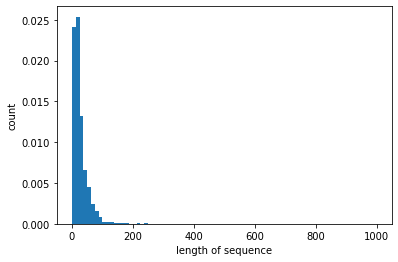

문장 최대 길이 : 999
min=0, max=999, mean=27.097073312083452, Q2=19.0 Q3=34.0


In [1127]:
data_train.plot_len()

In [1097]:
char2idx = data_train.char2idx
idx2char = data_train.idx2char

## 모델 저장

In [1098]:
torch.save(model.state_dict(), './check_point/1dcnn_state.pt')

## 모델 불러오기

In [1099]:
torch.manual_seed(55)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [1100]:
model = Net(data_train.vocab_size, data_train.get_q3())
model.load_state_dict(torch.load('./check_point/1dcnn_state.pt'))
model.eval()
model.to(device)

Net(
  (embedding): Embedding(1668, 500)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(500, 128, kernel_size=(4,), stride=(1,))
  (conv_1): Conv1d(500, 128, kernel_size=(5,), stride=(1,))
  (conv_2): Conv1d(500, 128, kernel_size=(6,), stride=(1,))
  (dropout): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=384, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [1108]:
sentence = '안녕'
model.eval()
with torch.no_grad():
    korean = re.compile('[^1!ㄱ-ㅣ가-힣]+')
    chars = korean.sub('', sentence)
    chars = [x for x in chars]
    if len(chars) < 34:
        need_pad = 34 - len(chars)
        chars.extend(['<PAD>']*need_pad)
    else:
        chars = chars[:self.q3]
    chars = torch.tensor([char2idx[x] for x in chars]).to(torch.int64).to(device)
    chars = torch.unsqueeze(chars, 0)
    prt = [idx2char[x.item()] for x in chars.squeeze()]
    print(prt)
    print(chars)
    outputs = model(chars)
    print(outputs)

['안', '녕', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
tensor([[ 967,  284, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667,
         1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667,
         1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667, 1667]],
       device='cuda:0')
tensor(0.2403, device='cuda:0')


In [561]:
def inference(sentence, model):
    model.eval()
    with torch.no_grad():
        korean = re.compile('[^1!ㄱ-ㅣ가-힣]+')
        chars = korean.sub('', sentence)
        chars = [x for x in chars]
        if len(chars) < 34:
            need_pad = 34 - len(chars)
            chars.extend(['<PAD>']*need_pad)
        else:
            chars = chars[:self.q3]
        chars = torch.tensor([char2idx[x] for x in chars]).to(torch.int64).to(device)
        chars = torch.unsqueeze(chars, 0)
        prt = [idx2char[x.item()] for x in chars.squeeze()]
        print(prt)
        print(chars)
        outputs = model(chars)
        print(outputs)